In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import sklearn
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
jewelry_df_bracelet_clean = pd.read_pickle('clean_bracelet_df.pkl')

In [5]:
jewelry_df_bracelet_clean.columns

Index(['category_id', 'category_path', 'category_path_ids', 'creation_tsz',
       'currency_code', 'description', 'ending_tsz', 'featured_rank',
       'file_data', 'has_variations', 'is_customizable', 'is_digital',
       'is_private', 'is_supply', 'item_dimensions_unit', 'item_height',
       'item_length', 'item_weight', 'item_weight_unit', 'item_width',
       'language', 'last_modified_tsz', 'listing_id', 'materials',
       'non_taxable', 'num_favorers', 'occasion', 'original_creation_tsz',
       'price', 'processing_max', 'processing_min', 'quantity', 'recipient',
       'shipping_template_id', 'shop_section_id', 'should_auto_renew', 'sku',
       'state', 'state_tsz', 'style', 'suggested_taxonomy_id', 'tags',
       'taxonomy_id', 'taxonomy_path', 'title', 'url', 'used_manufacturer',
       'user_id', 'views', 'when_made', 'who_made'],
      dtype='object')

#### Try k-means clustering on ONLY numeric columns

In [6]:
cluster_columns = ['featured_rank','has_variations', 'is_customizable', 'num_favorers']

##### Handle Nans - fill with 0

In [23]:
#Fill Nans as 0s for Featured Rank, Processing min and max columns

jewelry_df_bracelet_clean.featured_rank = jewelry_df_bracelet_clean.featured_rank.fillna(0)
jewelry_df_bracelet_clean.processing_max = jewelry_df_bracelet_clean.processing_max.fillna(0)
jewelry_df_bracelet_clean.processing_min = jewelry_df_bracelet_clean.processing_min.fillna(0)

In [62]:
#check num of records where Processing Max & Min is Nan
jewelry_df_bracelet_clean[['processing_max', 'processing_min']].isna().sum()

processing_max    1873
processing_min    1873
dtype: int64

##### If product has no listing id, or title or URL - invalid data point - drop rows

In [42]:
#Drop listings for which there's no title or url - messy data
idx = jewelry_df_bracelet_clean[['listing_id','title','url']][jewelry_df_bracelet_clean.num_favorers.isna()].index

jewelry_df_bracelet_clean = jewelry_df_bracelet_clean.drop(index=idx)

##### Create Train Test Split on jewelry bracelet df

In [64]:
(X_train, X_test) = train_test_split(jewelry_df_bracelet_clean,test_size=0.30)
# Cluster using SOME columns
# km = KMeans(n_clusters=8)
# kmeans = km.fit(X_train[['featured_rank',#'has_variations', 'is_customizable', 
#                          'num_favorers','processing_max', 'processing_min']])

In [65]:
# kmeans.cluster_centers_

array([[7.46513381e-01, 6.01388365e+00, 3.33135444e+00, 1.69616158e+00],
       [6.96428571e-01, 1.04748214e+03, 4.17857143e+00, 2.19642857e+00],
       [4.92063492e-01, 5.11513228e+02, 4.55026455e+00, 2.42328042e+00],
       [0.00000000e+00, 3.44300000e+03, 3.14285714e+00, 1.28571429e+00],
       [6.49224806e-01, 2.14085271e+02, 4.07364341e+00, 2.08139535e+00],
       [1.11028571e+03, 7.00000000e+00, 3.85714286e+00, 1.00000000e+00],
       [2.80000000e-01, 1.98888000e+03, 4.56000000e+00, 2.72000000e+00],
       [3.01450589e-01, 6.75018132e+01, 4.09474161e+00, 2.13780598e+00]])

#### Run the Kmeas to find optimal 'k' from elbow plot

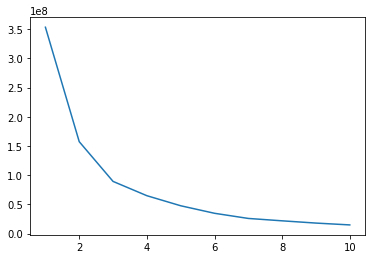

In [66]:
inertia = []

num_clusters = range(1,11)

for cluster in num_clusters:
    km = KMeans(n_clusters=cluster)
    km.fit(X_train[['featured_rank','processing_max', 
                    'processing_min', 'num_favorers']])
    inertia.append(km.inertia_)

plt.plot(list(num_clusters), inertia);

###### Looks like 3 (can also try 4/5)

In [67]:
km = KMeans(n_clusters=3)
km.fit(X_train[['featured_rank','processing_max', 
                    'processing_min', 'num_favorers']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [68]:
km.cluster_centers_

array([[1.16314796e+00, 3.38829679e+00, 1.72824161e+00, 1.19144475e+01],
       [1.66666667e-01, 3.80952381e+00, 2.09523810e+00, 2.08923810e+03],
       [1.04569892e+00, 4.40860215e+00, 2.31451613e+00, 4.89432796e+02]])

In [78]:
#Cluster Labels (0,1,2)
np.unique(km.labels_)

array([0, 1, 2], dtype=int32)

##### Create a copy of the train dataframe to map clusters to all cols 

In [80]:
X_train_labeled = X_train.copy()

In [82]:
X_train_labeled['Cluster_Label'] = km.labels_

In [90]:
X_train_labeled.Cluster_Label.value_counts()

0    34435
2      372
1       42
Name: Cluster_Label, dtype: int64

##### Avg Price per cluster - Naiive way to predict price

In [103]:
# X_train_labeled[['listing_id','title','featured_rank','processing_max', 
#                     'processing_min', 'num_favorers', 'Cluster_Label']]

price_clust_1 = X_train_labeled[X_train_labeled.Cluster_Label ==1][['listing_id','title','price',
                                                                    'featured_rank','processing_max', 
                    'processing_min', 'num_favorers', 'Cluster_Label']].price

In [118]:
price_clust_1 = pd.to_numeric(price_clust_1)

In [120]:
price_clust_1.mean()

74.39214285714286

In [141]:
X_train_labeled.price = X_train_labeled.price.astype(float)

Create DF for avg price per cluster from train dataset

In [145]:
price_clust_df = X_train_labeled.groupby('Cluster_Label')['price'].mean().reset_index()

In [146]:
price_clust_df

,Cluster_Label,price
0,0,86.709688
1,1,74.392143
2,2,100.765780


In [154]:
float(price_clust_df.price[price_clust_df.Cluster_Label == 0])

86.7096878176342

#### Assign to New items

In [148]:
X_test[['featured_rank','processing_max', 
                    'processing_min', 'num_favorers']].head(1)

,featured_rank,processing_max,processing_min,num_favorers
40274,0.0,3.0,1.0,8.0


In [123]:
# km.fit(X_train[['featured_rank','processing_max', 
#                     'processing_min', 'num_favorers']])

In [162]:
int(km.predict(X_test[['featured_rank','processing_max', 
                    'processing_min', 'num_favorers']].head(1)) )

0

##### Function that takes user input and returns suggested price

In [163]:
def predict_avg_price(df):
    clust = int(km.predict(df))
    return float(price_clust_df.price[price_clust_df.Cluster_Label == clust])

In [164]:
predict_avg_price(X_test[['featured_rank','processing_max','processing_min', 'num_favorers']].head(1))

86.7096878176342